In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

(16338, 128, 128, 7)
Dataset contains 16338 images with 7 channels each, of size 128x128.


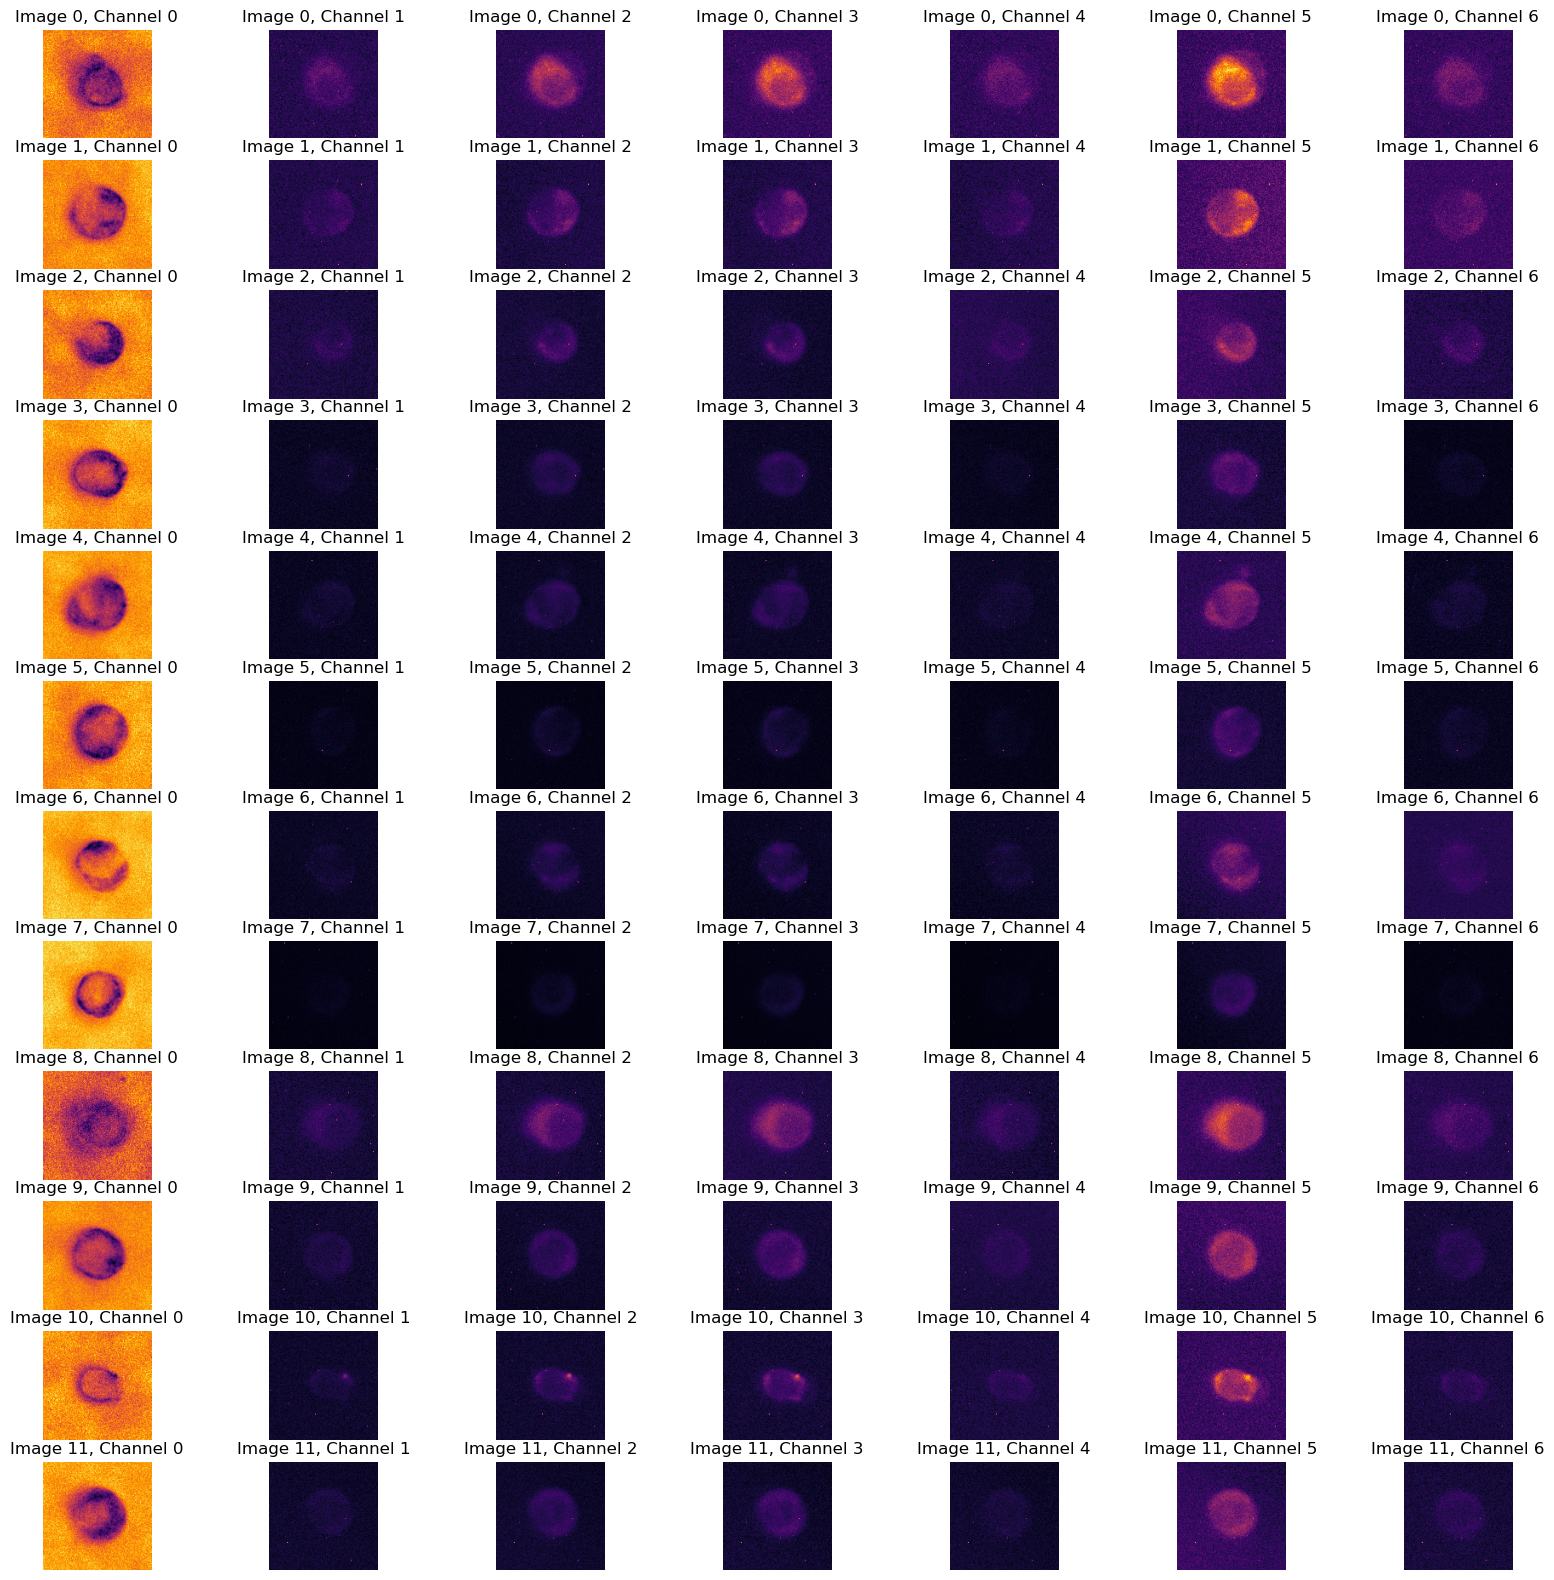

In [2]:
def display_transposedimages_from_hdf5(file_path, num_images_to_display=12):
    with h5py.File(file_path, 'r') as f:
        # Access the dataset
        images_dataset = f['images']
        num_images, height, width, num_channels = images_dataset.shape
        print(images_dataset.shape)
        
        print(f"Dataset contains {num_images} images with {num_channels} channels each, of size {height}x{width}.")

        # Display the first few images
        
        plt.figure(figsize=(20, 20))
        for i in range(min(num_images_to_display, num_images)):
            for j in range(images_dataset.shape[-1]):  # Loop over channels in NHWC format
                img = images_dataset[i, :, :, j]
                plt.subplot(num_images_to_display, images_dataset.shape[-1], i * images_dataset.shape[-1] + j + 1)
                plt.imshow(img, cmap='inferno')
                plt.title(f'Image {i}, Channel {j}')
                plt.axis('off')
            
        plt.show()
        return images_dataset
 
output_file_path = 'fluor_images_transposed.h5'
images_dataset_transposed = display_transposedimages_from_hdf5(output_file_path)


In [3]:
from keras import backend as K
K.set_image_data_format('channels_last')

**PatchGAN Discriminator**

In [4]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv3D, LeakyReLU, Activation, Concatenate, BatchNormalization, Lambda, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal

def define_discriminator(input_shape_2d, output_shape_3d):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    
    # source image input (2D brightfield)
    in_src_image = Input(shape=input_shape_2d)
    
    # target image input (3D fluorescence)
    in_target_image = Input(shape=output_shape_3d)
    
    # Expand dimensions of source image to match target image
    #expanded_src = Lambda(lambda x: tf.expand_dims(x, axis=-1), 
                          #output_shape=lambda input_shape: input_shape + (1,))(in_src_image)

    
    # Expand dimensions of source image to match target image
    expanded_src = Lambda(lambda x: tf.expand_dims(x, axis=-1),
                          output_shape=lambda input_shape: input_shape + (1,))(in_src_image)

    expanded_src = Lambda(lambda x: tf.tile(x, [1, 1, 1, 1, output_shape_3d[-1]]),
                          output_shape=lambda input_shape: input_shape[:-1] + (output_shape_3d[-1],))(expanded_src)

    expanded_src = Reshape((input_shape_2d[0], input_shape_2d[1], output_shape_3d[-1]))(expanded_src)

    # concatenate images channel-wise
    merged = Concatenate(axis=-1)([expanded_src, in_target_image])
    
    # Reshape merged tensor to 5D for Conv3D
    merged = Reshape((128, 128, output_shape_3d[-1] * 2, 1))(merged)
    
    # C64
    d = Conv3D(64, (4,4,4), strides=(2,2,2), padding='same', kernel_initializer=init)(merged)
    d = LeakyReLU(alpha=0.2)(d)
    
    # C128
    d = Conv3D(128, (4,4,4), strides=(2,2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    
    # C256
    d = Conv3D(256, (4,4,4), strides=(2,2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    
    # C512
    d = Conv3D(512, (4,4,4), strides=(2,2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    
    # second last output layer
    d = Conv3D(512, (4,4,4), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    
    # patch output
    d = Conv3D(1, (4,4,4), padding='same', kernel_initializer=init)(d)
    patch_out = Activation('sigmoid')(d)
    
    # define model
    model = Model([in_src_image, in_target_image], patch_out)
    
    # compile model
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    
    return model

# define image shapes
input_shape_2d = (128, 128, 1)  # 2D brightfield image
output_shape_3d = (128, 128, 6)  # 3D fluorescence image with 6 channels

# create the model
model = define_discriminator(input_shape_2d, output_shape_3d)

# summarize the model
model.summary()


2024-07-27 23:27:03.123714: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2024-07-27 23:27:03.123729: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2024-07-27 23:27:03.123733: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
2024-07-27 23:27:03.123918: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-07-27 23:27:03.123930: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/Users/anagharamadas/anaconda3/envs/GPU/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope`

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 128, 128,  │          0 │ input_layer[0][0] │
│                     │ 1, 1)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 128, 128,  │          0 │ lambda[0][0]      │
│                     │ 1, 6)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 128, 128,  │          0 │ lambda_1[0][0]    │
│                     │ 6)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 6)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128, 128,  │          0 │ reshape[0][0],    │
│ (Concatenate)       │ 12)               │            │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 128, 128,  │          0 │ concatenate[0][0] │
│                     │ 12, 1)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d (Conv3D)     │ (None, 64, 64, 6, │      4,160 │ reshape_1[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 64, 64, 6, │          0 │ conv3d[0][0]      │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_1 (Conv3D)   │ (None, 32, 32, 3, │    524,416 │ leaky_re_lu[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 32, 32, 3, │        512 │ conv3d_1[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 32, 32, 3, │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_2 (Conv3D)   │ (None, 16, 16, 2, │  2,097,408 │ leaky_re_lu_1[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16, 2, │      1,024 │ conv3d_2[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 16, 16, 2, │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_3 (Conv3D)   │ (None, 8, 8, 1,   │  8,389,120 │ leaky_re_lu_2[0]… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 1,   │      2,048 │ conv3d_3[0][0]  

 Total params: 27,831,233 (106.17 MB)

 Trainable params: 27,828,417 (106.16 MB)

 Non-trainable params: 2,816 (11.00 KB)

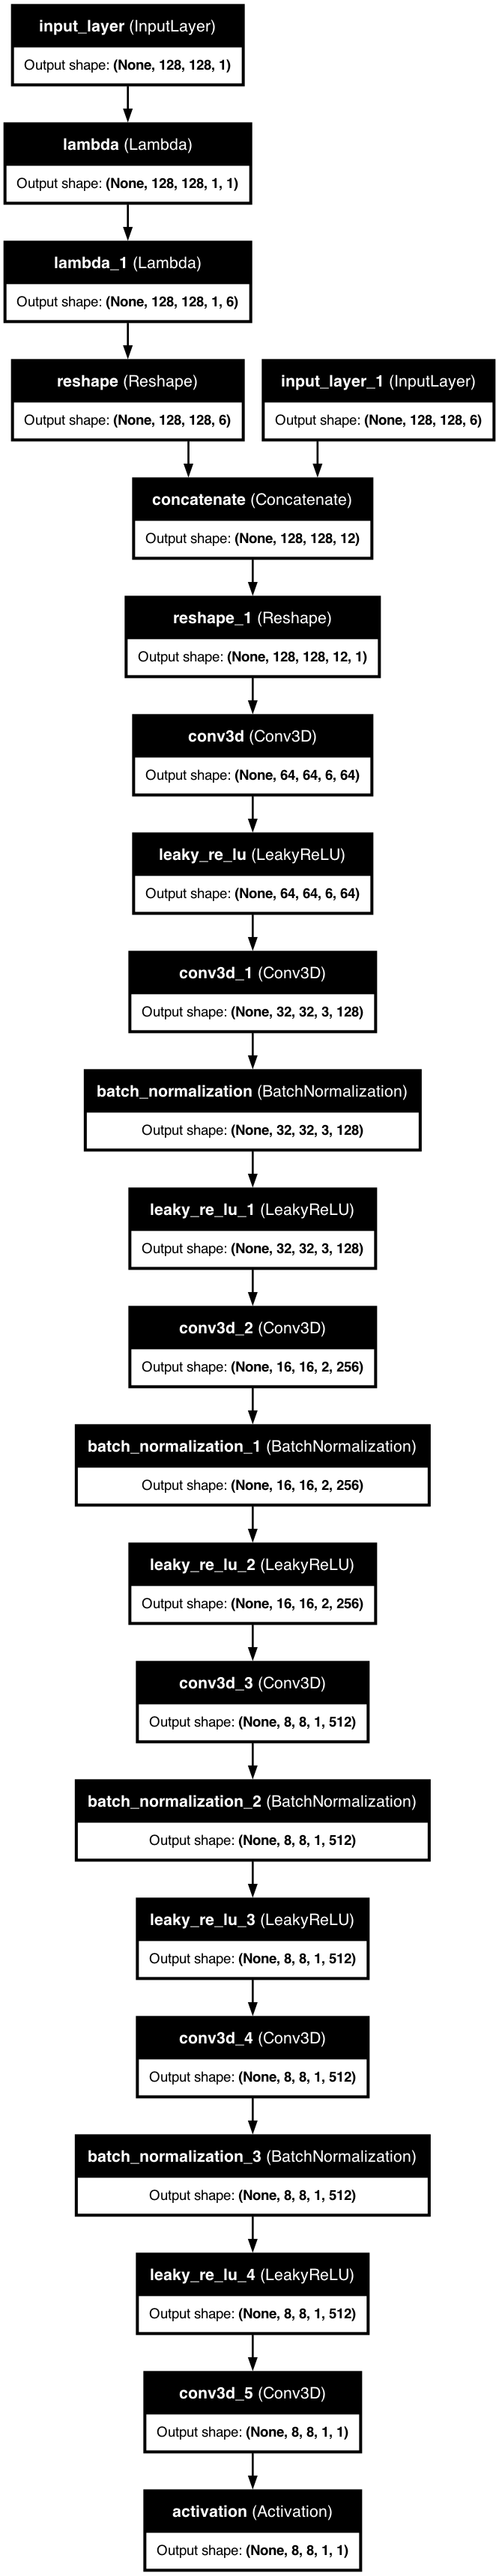

In [5]:
from tensorflow.keras.utils import plot_model
import tensorflow as tf

# After defining your model
tf.keras.utils.plot_model(
    model,
    to_file="discriminator_model_plot.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=96,
)

# U-Net Generator

In [6]:
# example of defining a u-net encoder-decoder generator model
from keras.initializers import RandomNormal
from keras.models import Model
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
#from keras.utils.vis_utils import plot_model

# define an encoder block
def define_encoder_block(layer_in, n_filters, batchnorm=True):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # add downsampling layer
    g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init, data_format='channels_last')(layer_in)
    # conditionally add batch normalization
    if batchnorm:
        g = BatchNormalization()(g, training=True)
    # leaky relu activation
    g = LeakyReLU(alpha=0.2)(g)
    return g

# define a decoder block
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # add upsampling layer
    g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init, data_format='channels_last')(layer_in)
    # add batch normalization
    g = BatchNormalization()(g, training=True)
    # conditionally add dropout
    if dropout:
        g = Dropout(0.5)(g, training=True)
    # merge with skip connection
    g = Concatenate()([g, skip_in])
    # relu activation
    g = Activation('relu')(g)
    return g

# define the standalone generator model
def define_generator(image_shape=(128, 128, 1), output_channels = 6):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # image input
    in_image = Input(shape=image_shape)
    # encoder model: C64-C128-C256-C512-C512-C512-C512-C512
    e1 = define_encoder_block(in_image, 64, batchnorm=False)
    e2 = define_encoder_block(e1, 128)
    e3 = define_encoder_block(e2, 256)
    e4 = define_encoder_block(e3, 512)
    e5 = define_encoder_block(e4, 512)
    e6 = define_encoder_block(e5, 512)
    #e7 = define_encoder_block(e6, 512)
    # bottleneck, no batch norm and relu
    b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init, data_format='channels_last')(e6)
    b = Activation('relu')(b)
    # decoder model: CD512-CD1024-CD1024-C1024-C1024-C512-C256-C128
    d1 = decoder_block(b, e6, 512)
    d2 = decoder_block(d1, e5, 512)
    d3 = decoder_block(d2, e4, 512)
    #d4 = decoder_block(d3, e4, 512, dropout=False)
    d4 = decoder_block(d3, e3, 256, dropout=False)
    d5 = decoder_block(d4, e2, 128, dropout=False)
    d6 = decoder_block(d5, e1, 64, dropout=False)
    # output
    out_image = Conv2DTranspose(output_channels, (4,4), strides=(2,2), padding='same', kernel_initializer=init, data_format='channels_last')(d6)
    #out_image = Activation('tanh')(g)
    # define model
    model = Model(in_image, out_image)
    return model

# define image shape
image_shape = (128, 128, 1)

output_channels = 6
# create the model
model = define_generator(image_shape, output_channels)
# summarize the model
model.summary()
# plot the model
#plot_model(model, to_file='generator_model_plot.png', show_shapes=True, show_layer_names=True)


/Users/anagharamadas/anaconda3/envs/GPU/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 64, 64,    │      1,088 │ input_layer_2[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_5       │ (None, 64, 64,    │          0 │ conv2d[0][0]      │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 32, 32,    │    131,200 │ leaky_re_lu_5[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_6       │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 16, 16,    │    524,544 │ leaky_re_lu_6[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │      1,024 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_7       │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 8, 8, 512) │  2,097,664 │ leaky_re_lu_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 512) │      2,048 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_8       │ (None, 8, 8, 512) │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 4, 4, 512) │  4,194,816 │ leaky_re_lu_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4, 4, 512) │      2,048 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_9       │ (None, 4, 4, 512) │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 2, 2, 512) │  4,194,816 │ leaky_re_lu_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2, 2, 512) │      2,048 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_10      │ (None, 2, 2, 512) │          0 │ batch_normalizat

 Total params: 41,845,382 (159.63 MB)

 Trainable params: 41,837,574 (159.60 MB)

 Non-trainable params: 7,808 (30.50 KB)

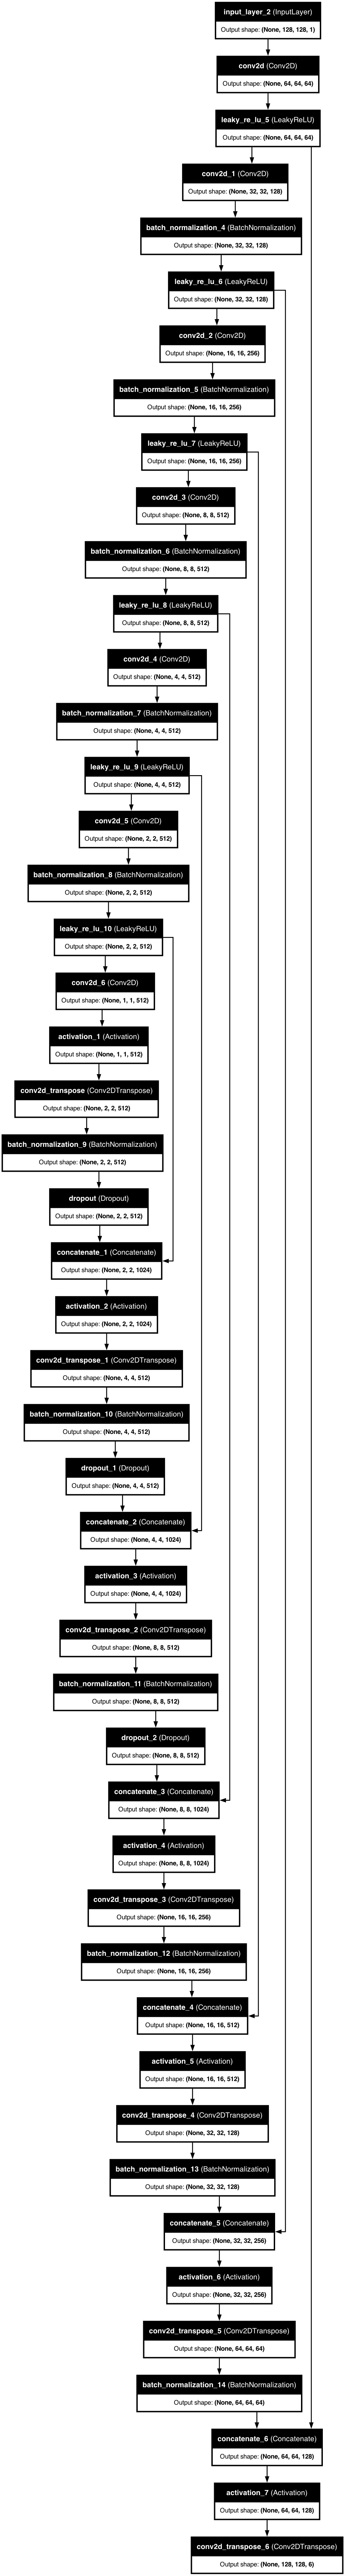

In [7]:
from tensorflow.keras.utils import plot_model
import tensorflow as tf

# After defining your model
tf.keras.utils.plot_model(
    model,
    to_file="generator_model_plot.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=96
)

In [8]:

# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model, image_shape):
 # make weights in the discriminator not trainable
 for layer in d_model.layers:
     if not isinstance(layer, BatchNormalization):
         layer.trainable = True
 # define the source image
 in_src = Input(shape=image_shape)
 # connect the source image to the generator input
 gen_out = g_model(in_src)
 # connect the source input and generator output to the discriminator input
 dis_out = d_model([in_src, gen_out])
 # src image as input, generated image and classification output
 model = Model(in_src, [dis_out, gen_out])
 # compile model
 opt = Adam(learning_rate=0.0002, beta_1=0.5)
 model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1,100])
 return model

/Users/anagharamadas/anaconda3/envs/GPU/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_7        │ (None, 128, 128,  │ 41,845,382 │ input_layer_6[0]… │
│ (Functional)        │ 6)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_5        │ (None, 8, 8, 1,   │ 27,831,233 │ input_layer_6[0]… │
│ (Functional)        │ 1)                │            │ functional_7[0][… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 69,676,615 (265.80 MB)

 Trainable params: 69,665,991 (265.75 MB)

 Non-trainable params: 10,624 (41.50 KB)

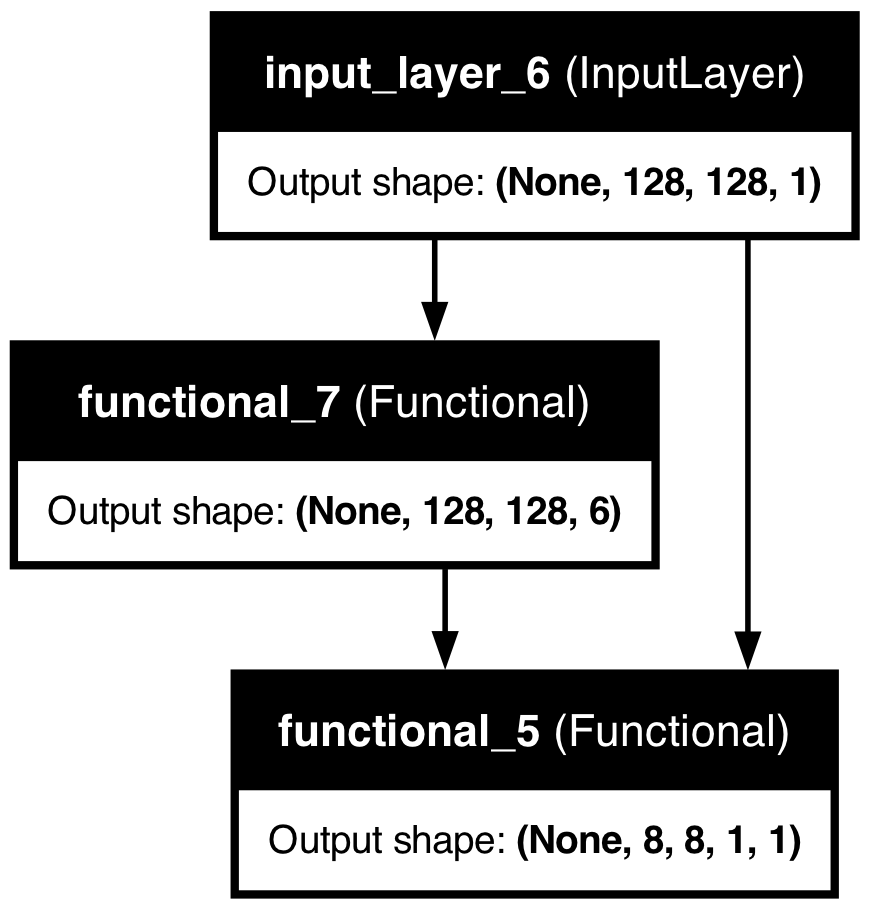

In [9]:
# define image shape
image_shape = (128, 128, 1)
output_shape_3d = (128, 128, 6)
# define the models
d_model = define_discriminator(image_shape, output_shape_3d)
g_model = define_generator(image_shape)
# define the composite model
gan_model = define_gan(g_model, d_model, image_shape)
# summarize the model
gan_model.summary()
# plot the model
plot_model(gan_model, to_file='gan_model_plot.png', show_shapes=True, show_layer_names=True)

# Updating the model weights

In [10]:

import numpy as np
from numpy.random import randint
from numpy import ones
from numpy import zeros
import tensorflow as tf

def split_dataset(dataset):
    # Check the dimensions of the dataset
    if dataset.shape != (2000, 128, 128, 7):
        raise ValueError('Dataset dimensions do not match the expected shape (16338, 128, 128, 7)')
    
    
    # Extract the brightfield images (channel 0)
    brightfield_images = dataset[:, :, :, 0]

    # Extract the fluorescence images (channels 1-6)
    fluorescence_images = dataset[:, :, :, 1:7]

    # Verify the shapes
    print("Brightfield images shape:", brightfield_images.shape)  # Should be (16338, 128, 128)
    print("Fluorescence images shape:", fluorescence_images.shape)  # Should be (16338, 128, 128, 6)

    return brightfield_images, fluorescence_images



In [11]:
# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
    # unpack dataset
    trainA, trainB = split_dataset(dataset)
    print('trainA shape:', trainA.shape)
    print('trainB shape:', trainB.shape)
    # choose random instances
    ix = randint(0, trainA.shape[0], n_samples)
    # retrieve selected images
    X1, X2 = trainA[ix], trainB[ix]
    # generate 'real' class labels (1)
    y = np.ones((n_samples, patch_shape, patch_shape, 1))
    return [X1, X2], y

In [12]:
# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, samples, patch_shape): 
    # Ensure samples are in channels_last format

    # generate fake instance
    X = g_model.predict(samples)
    # create 'fake' class labels (0)
    y = np.zeros((len(X),patch_shape, patch_shape, 1))
    return X, y

In [13]:
def check_dataset_format(file_path):
    with h5py.File(file_path, 'r') as f:
        # Access the dataset
        images_dataset = f['images']
        num_images, height, width, num_channels = images_dataset.shape
        print(f"Dataset shape: {images_dataset.shape}")
        print(f"Dataset contains {num_images} images with {num_channels} channels each, of size {height}x{width}.")
        
        # Verify the datatype
        datatype = images_dataset.dtype
        print(f"Image datatype: {datatype}")

        # Check if the dataset follows NHWC format
        if len(images_dataset.shape) == 4 and images_dataset.shape[1] == height and images_dataset.shape[2] == width and images_dataset.shape[3] == num_channels:
            print("Dataset follows NHWC format.")
        else:
            print("Dataset does not follow NHWC format.")
        
        return images_dataset

# Usage
file_path = 'fluor_images_transposed.h5'
images_dataset = check_dataset_format(file_path)

Dataset shape: (16338, 128, 128, 7)
Dataset contains 16338 images with 7 channels each, of size 128x128.
Image datatype: uint16
Dataset follows NHWC format.


In [14]:
n_batch = 1000
n_patch = 8
print(images_dataset.shape)
file_path = 'fluor_images_transposed.h5'

# Open the file and keep it open
f = h5py.File(file_path, 'r')
images_dataset = f['images']
import numpy as np


# Number of images to extract
num_images_to_extract = 2000

# Randomly select 2000 indices from the dataset
indices = np.arange(2000)

# Extract the selected images
extracted_images = images_dataset[indices]
images_dataset = extracted_images

# Check the shape of the extracted images
print("Extracted images shape:", extracted_images.shape)

#images_dataset = normalized_dataset(images_dataset)


# select a batch of real samples
[X_realA, X_realB], y_real = generate_real_samples(images_dataset, n_batch, n_patch)
print(X_realA.shape)
print(X_realB.shape)
print(y_real.shape)

(16338, 128, 128, 7)
Extracted images shape: (2000, 128, 128, 7)
Brightfield images shape: (2000, 128, 128)
Fluorescence images shape: (2000, 128, 128, 6)
trainA shape: (2000, 128, 128)
trainB shape: (2000, 128, 128, 6)
(1000, 128, 128)
(1000, 128, 128, 6)
(1000, 8, 8, 1)


In [15]:
def brightfield_images(minimum_value, maximum_value):
    for i in range(images_dataset.shape[0]):
        img = images_dataset[i, :, :, 0]
        if(img.min() <minimum_value):
            minimum_value = img.min()
        if(img.max() > maximum_value):
            maximum_value = img.max()

    return [minimum_value, maximum_value] 

def channel1_images(minimum_value, maximum_value):
    for i in range(images_dataset.shape[0]):
        img = images_dataset[i, :, :, 1]
        if(img.min() <minimum_value):
            minimum_value = img.min()
        if(img.max() > maximum_value):
            maximum_value = img.max()
    return [minimum_value, maximum_value]


def channel2_images(minimum_value, maximum_value):
    for i in range(images_dataset.shape[0]):
        img = images_dataset[i, :, :, 2]
        if(img.min() <minimum_value):
            minimum_value = img.min()
        if(img.max() > maximum_value):
            maximum_value = img.max()

    return [minimum_value, maximum_value]

def channel3_images(minimum_value, maximum_value):
    for i in range(images_dataset.shape[0]):
        img = images_dataset[i, :, :, 3]
        if(img.min() < minimum_value):
            minimum_value = img.min()
        if(img.max() > maximum_value):
            maximum_value = img.max()
    return [minimum_value, maximum_value]

def channel4_images(minimum_value, maximum_value):
    for i in range(images_dataset.shape[0]):
        img = images_dataset[i, :, :, 4]
        if(img.min() < minimum_value):
            minimum_value = img.min()
        if(img.max() > maximum_value):
            maximum_value = img.max()
    return [minimum_value, maximum_value]

def channel5_images(minimum_value, maximum_value):
    for i in range(images_dataset.shape[0]):
        img = images_dataset[i, :, :, 5]
        if(img.min() < minimum_value):
            minimum_value = img.min()
        if(img.max() > maximum_value):
            maximum_value = img.max()
    return [minimum_value, maximum_value]

def channel6_images(minimum_value, maximum_value):
    for i in range(images_dataset.shape[0]):
        img = images_dataset[i, :, :, 6]
        if(img.min() <minimum_value):
            minimum_value = img.min()
        if(img.max() > maximum_value):
            maximum_value = img.max()
    return [minimum_value, maximum_value]

def normalization_process(image, min_val, max_val):
    image = ((image.astype(np.float32) - min_val) / (max_val - min_val) * 65535).astype(np.uint16)
    return image


In [16]:
def normalization_of_images(images_dataset):
    
    minimum_value_bf =  np.min(images_dataset[0, :, :, 0])  
    maximum_value_bf = np.max(images_dataset[0, :, :, 0])
    
    minimum_value_1 =  np.min(images_dataset[0, :, :, 1])  
    maximum_value_1 = np.max(images_dataset[0, :, :, 1])
    
    minimum_value_2 =  np.min(images_dataset[0, :, :, 2])  
    maximum_value_2 = np.max(images_dataset[0, :, :, 2])
    
    minimum_value_3 =  np.min(images_dataset[0, :, :, 3])  
    maximum_value_3 = np.max(images_dataset[0, :, :, 3])
    
    minimum_value_4 =  np.min(images_dataset[0, :, :, 4])  
    maximum_value_4 = np.max(images_dataset[0, :, :, 4])
    
    minimum_value_5 =  np.min(images_dataset[0, :, :, 5])  
    maximum_value_5 = np.max(images_dataset[0, :, :, 5])

    minimum_value_6 =  np.min(images_dataset[0, :, :, 6])  
    maximum_value_6 = np.max(images_dataset[0, :, :, 6])
    
    
    minimum_value_bf, maximum_value_bf =  brightfield_images(minimum_value_bf, maximum_value_bf) 
    minimum_value_1, maximum_value_1 =  channel1_images(minimum_value_1, maximum_value_1) 
    minimum_value_2, maximum_value_2 =  channel2_images(minimum_value_2, maximum_value_2) 
    minimum_value_3, maximum_value_3 =  channel3_images(minimum_value_3, maximum_value_3) 
    minimum_value_4, maximum_value_4 =  channel4_images(minimum_value_4, maximum_value_4) 
    minimum_value_5, maximum_value_5 =  channel5_images(minimum_value_5, maximum_value_5) 
    minimum_value_6, maximum_value_6 =  channel6_images(minimum_value_6, maximum_value_6) 
    
   
    
    
    for i in range(images_dataset.shape[0]):
        for j in range(images_dataset.shape[-1]):
            if(j==0):
                image = images_dataset[i, :, :, 0]
                temp_image = normalization_process(image, minimum_value_bf, maximum_value_bf)
                images_dataset[i, :, :, j] = temp_image
                
            if(j==1):
                image = images_dataset[i, :, :, 1]
                temp_image = normalization_process(image, minimum_value_1, maximum_value_1)
                images_dataset[i, :, :, j] = temp_image
                
            if(j==2):
                image = images_dataset[i, :, :, 2]
                temp_image = normalization_process(image, minimum_value_1, maximum_value_2)
                images_dataset[i, :, :, j] = temp_image
            
            if(j==3):
                image = images_dataset[i, :, :, 3]
                temp_image = normalization_process(image, minimum_value_1, maximum_value_3)
                images_dataset[i, :, :, j] = temp_image
                
            if(j==4):
                image = images_dataset[i, :, :, 4]
                temp_image = normalization_process(image, minimum_value_1, maximum_value_4)
                images_dataset[i, :, :, j] = temp_image
                
            if(j==5):
                image = images_dataset[i, :, :, 5]
                temp_image = normalization_process(image, minimum_value_1, maximum_value_5)
                images_dataset[i, :, :, j] = temp_image
                
            if(j==6):
                image = images_dataset[i, :, :, 6]
                temp_image = normalization_process(image, minimum_value_1, maximum_value_6)
                images_dataset[i, :, :, j] = temp_image
            
        

    
    
                
    print("minimum value in channel of brightfield images = ", minimum_value_bf)
    print("maximum value in channel of brightfield images = ", maximum_value_bf)
    print() 
    
    print("minimum value in channel 1 of images = ", minimum_value_1)
    print("maximum value in channel 1 of images = ", maximum_value_1)
    print() 
    
    print("minimum value in channel 2 of images = ", minimum_value_2)
    print("maximum value in channel 2 of images = ", maximum_value_2)
    print() 
    
    print("minimum value in channel 3 of images = ", minimum_value_3)
    print("maximum value in channel 3 of images = ", maximum_value_3)
    print() 
    
    print("minimum value in channel 4 of images = ", minimum_value_4)
    print("maximum value in channel 4 of images = ", maximum_value_4)
    print() 
    
    print("minimum value in channel 5 of images = ", minimum_value_5)
    print("maximum value in channel 5 of images = ", maximum_value_5)
    print() 
    
    print("minimum value in channel 6 of images = ", minimum_value_6)
    print("maximum value in channel 6 of images = ", maximum_value_6)
    print()
    
    print("shape of normalized images dataset = ", images_dataset.shape)
    #print("maximum value in channel 6 of images = ", maximum_value_6)
    print()
    
    return images_dataset
    



In [17]:
images_dataset = normalization_of_images(images_dataset)


/var/folders/g9/hbn9851d54v_tl_jf_58lppw0000gn/T/ipykernel_98942/2495166284.py:68: RuntimeWarning: invalid value encountered in cast
  image = ((image.astype(np.float32) - min_val) / (max_val - min_val) * 65535).astype(np.uint16)


minimum value in channel of brightfield images =  1072
maximum value in channel of brightfield images =  3368

minimum value in channel 1 of images =  38
maximum value in channel 1 of images =  788

minimum value in channel 2 of images =  45
maximum value in channel 2 of images =  956

minimum value in channel 3 of images =  34
maximum value in channel 3 of images =  784

minimum value in channel 4 of images =  28
maximum value in channel 4 of images =  595

minimum value in channel 5 of images =  63
maximum value in channel 5 of images =  702

minimum value in channel 6 of images =  13
maximum value in channel 6 of images =  317

shape of normalized images dataset =  (2000, 128, 128, 7)



In [18]:
print(images_dataset.dtype)

uint16


In [19]:
def min_and_max_images(images_dataset):    
    minimum_value_bf =  np.min(images_dataset[0, :, :, 0])  
    maximum_value_bf = np.max(images_dataset[0, :, :, 0])

    minimum_value_1 =  np.min(images_dataset[0, :, :, 1])  
    maximum_value_1 = np.max(images_dataset[0, :, :, 1])

    minimum_value_2 =  np.min(images_dataset[0, :, :, 2])  
    maximum_value_2 = np.max(images_dataset[0, :, :, 2])

    minimum_value_3 =  np.min(images_dataset[0, :, :, 3])  
    maximum_value_3 = np.max(images_dataset[0, :, :, 3])

    minimum_value_4 =  np.min(images_dataset[0, :, :, 4])  
    maximum_value_4 = np.max(images_dataset[0, :, :, 4])

    minimum_value_5 =  np.min(images_dataset[0, :, :, 5])  
    maximum_value_5 = np.max(images_dataset[0, :, :, 5])

    minimum_value_6 =  np.min(images_dataset[0, :, :, 6])  
    maximum_value_6 = np.max(images_dataset[0, :, :, 6])
    
                    
    print("minimum value in channel of brightfield images = ", minimum_value_bf)
    print("maximum value in channel of brightfield images = ", maximum_value_bf)
    print() 
    
    print("minimum value in channel 1 of images = ", minimum_value_1)
    print("maximum value in channel 1 of images = ", maximum_value_1)
    print() 
    
    print("minimum value in channel 2 of images = ", minimum_value_2)
    print("maximum value in channel 2 of images = ", maximum_value_2)
    print() 
    
    print("minimum value in channel 3 of images = ", minimum_value_3)
    print("maximum value in channel 3 of images = ", maximum_value_3)
    print() 
    
    print("minimum value in channel 4 of images = ", minimum_value_4)
    print("maximum value in channel 4 of images = ", maximum_value_4)
    print() 
    
    print("minimum value in channel 5 of images = ", minimum_value_5)
    print("maximum value in channel 5 of images = ", maximum_value_5)
    print() 
    
    print("minimum value in channel 6 of images = ", minimum_value_6)
    print("maximum value in channel 6 of images = ", maximum_value_6)
    print()
    
    print("shape of normalized images dataset = ", images_dataset.shape)
    #print("maximum value in channel 6 of images = ", maximum_value_6)
    print()

In [20]:
min_and_max_images(images_dataset)

minimum value in channel of brightfield images =  44612
maximum value in channel of brightfield images =  63793

minimum value in channel 1 of images =  2009
maximum value in channel 1 of images =  14854

minimum value in channel 2 of images =  2070
maximum value in channel 2 of images =  14777

minimum value in channel 3 of images =  1581
maximum value in channel 3 of images =  13265

minimum value in channel 4 of images =  1058
maximum value in channel 4 of images =  14001

minimum value in channel 5 of images =  6810
maximum value in channel 5 of images =  22009

minimum value in channel 6 of images =  0
maximum value in channel 6 of images =  12919

shape of normalized images dataset =  (2000, 128, 128, 7)



In [21]:
print(y_real[0,7,7,0])


1.0


In [22]:
...

# generate a batch of fake samples
X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)


2024-07-27 23:27:05.457071: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step


-80.332016 149.78317
-97.36017 69.13151
-42.786346 104.461945
-37.070393 91.47425
-81.27848 85.1821


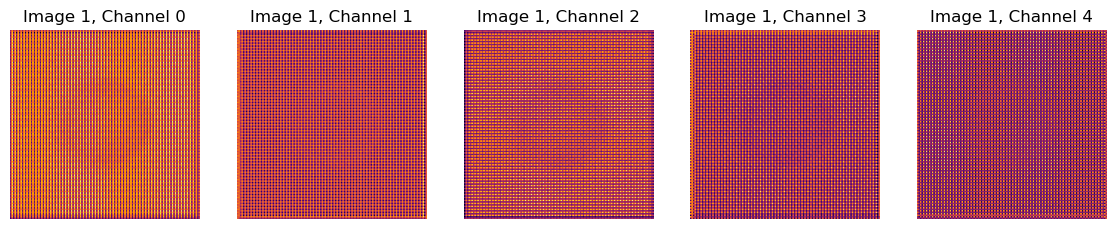

In [23]:
plt.figure(figsize=(20, 20))

for j in range(5):
    img = X_fakeB[0,:, :, j]
    plt.subplot(1, 7, 0 * 7 + j + 1)
    plt.imshow(img, cmap='inferno')
    plt.title(f'Image {1}, Channel {j}')
    plt.axis('off')
    print(img.min(), img.max())

plt.show()


In [24]:
print("X_realA shape:", X_realA.shape)
print("X_realB shape:", X_realB.shape)
print("y_real shape:", y_real.shape)
print("X_fakeB shape:", X_fakeB.shape)
print("y_fake shape:", y_fake.shape)

X_realA shape: (1000, 128, 128)
X_realB shape: (1000, 128, 128, 6)
y_real shape: (1000, 8, 8, 1)
X_fakeB shape: (1000, 128, 128, 6)
y_fake shape: (1000, 8, 8, 1)


In [25]:
# Get the discriminator's output for the generated images
disc_generated_output = d_model([X_realA, X_fakeB])


In [26]:

# Example model compilation for multiple outputs
d_model.compile(optimizer='Adam', loss='binary_crossentropy')
d_model.trainable = True
# update discriminator for real samples
#d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
# update discriminator for generated samples
#d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)


In [27]:
# Assuming you have already defined and created the gan_model
# Define the optimizer and compile the GAN model
from keras.optimizers import SGD
 
opt = Adam(learning_rate=0.0002)
gan_model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1, 100])

X_realA = X_realA.astype(np.float32)
X_realB = X_realB.astype(np.float32)

X_realA = (X_realA - 127.5) / 127.5
X_realB = (X_realB - 127.5) / 127.5

# Now you can call train_on_batch
#g_loss = gan_model.train_on_batch(X_realA, [y_real, X_realB])
#print(f"Generator loss on fake samples: {g_loss}")

In [28]:
import os
from tensorflow.keras.callbacks import Callback

class CustomModelCheckpoint(Callback):
    def __init__(self, g_model, d_model, gan_model, filepath, monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1):
        super(CustomModelCheckpoint, self).__init__()
        self.g_model = g_model
        self.d_model = d_model
        self.gan_model = gan_model
        self.filepath = filepath
        self.monitor = monitor
        self.verbose = verbose
        self.save_best_only = save_best_only
        self.save_weights_only = save_weights_only
        self.period = period
        self.epochs_since_last_save = 0

        if mode not in ['auto', 'min', 'max']:
            mode = 'auto'
        if mode == 'min':
            self.monitor_op = np.less
            self.best = float('inf')
        elif mode == 'max':
            self.monitor_op = np.greater
            self.best = float('-inf')
        else:
            if 'acc' in self.monitor or self.monitor.startswith('fmeasure'):
                self.monitor_op = np.greater
                self.best = float('-inf')
            else:
                self.monitor_op = np.less
                self.best = float('inf')

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        self.epochs_since_last_save += 1
        if self.epochs_since_last_save >= self.period:
            self.epochs_since_last_save = 0
            filepath = self.filepath.format(epoch=epoch + 1, **logs)
            if self.save_best_only:
                current = logs.get(self.monitor)
                if current is None:
                    warnings.warn(f'Can save best model only with {self.monitor} available, skipping.', RuntimeWarning)
                else:
                    if self.monitor_op(current, self.best):
                        if self.verbose > 0:
                            print(f'\nEpoch {epoch + 1}: {self.monitor} improved from {self.best:.5f} to {current:.5f}, saving model to {filepath}')
                        self.best = current
                        self._save_model(filepath, overwrite=True)
                    else:
                        if self.verbose > 0:
                            print(f'\nEpoch {epoch + 1}: {self.monitor} did not improve from {self.best:.5f}')
            else:
                if self.verbose > 0:
                    print(f'\nEpoch {epoch + 1}: saving model to {filepath}')
                self._save_model(filepath, overwrite=True)

    def _save_model(self, filepath, overwrite=True):
        if self.save_weights_only:
            self.g_model.save_weights(filepath + '_generator.h5', overwrite=overwrite)
            self.d_model.save_weights(filepath + '_discriminator.h5', overwrite=overwrite)
            self.gan_model.save_weights(filepath + '_gan.h5', overwrite=overwrite)
        else:
            self.g_model.save(filepath + '_generator.keras', overwrite=overwrite)
            self.d_model.save(filepath + '_discriminator.keras', overwrite=overwrite)
            self.gan_model.save(filepath + '_gan.keras', overwrite=overwrite)


In [29]:
import os
import shutil
"""
# Clear previous checkpoints
checkpoint_dir = 'checkpoints'
if os.path.exists(checkpoint_dir):
    print("checkpoint directory exists")
    shutil.rmtree(checkpoint_dir)
os.makedirs(checkpoint_dir)
"""


'\n# Clear previous checkpoints\ncheckpoint_dir = \'checkpoints\'\nif os.path.exists(checkpoint_dir):\n    print("checkpoint directory exists")\n    shutil.rmtree(checkpoint_dir)\nos.makedirs(checkpoint_dir)\n'

In [30]:
import os
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
import glob

checkpoint_dir = 'checkpoints'

os.makedirs(checkpoint_dir, exist_ok=True)
#checkpoint_prefix = os.path.join(checkpoint_dir, 'model_checkpoint_{epoch:02d}_{val_loss:.2f}')

In [31]:
latest_checkpoint = None

# Find the latest checkpoint file for each model
generator_checkpoints = glob.glob(os.path.join(checkpoint_dir, '*_generator.keras'))
discriminator_checkpoints = glob.glob(os.path.join(checkpoint_dir, '*_discriminator.keras'))
gan_checkpoints = glob.glob(os.path.join(checkpoint_dir, '*_gan.keras'))

if generator_checkpoints and discriminator_checkpoints and gan_checkpoints:
    latest_generator = max(generator_checkpoints, key=os.path.getctime)
    latest_discriminator = max(discriminator_checkpoints, key=os.path.getctime)
    latest_gan = max(gan_checkpoints, key=os.path.getctime)
    
    print(f"Found checkpoints:\nGenerator: {latest_generator}\nDiscriminator: {latest_discriminator}\nGAN: {latest_gan}")
    latest_checkpoint = True
else:
    print("No complete set of checkpoints found. Starting from scratch.")
    latest_checkpoint = None

Found checkpoints:
Generator: checkpoints/model_checkpoint_22_80368.48_generator.keras
Discriminator: checkpoints/model_checkpoint_22_80368.48_discriminator.keras
GAN: checkpoints/model_checkpoint_22_80368.48_gan.keras


In [32]:
#latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)
"""
starting_epoch = 0
if latest_checkpoint:
    print(f"Found checkpoint: {latest_checkpoint}")
    epoch_str = os.path.basename(latest_checkpoint).split('_')[2]
    starting_epoch = int(epoch_str)
    print(f"Resuming from epoch {starting_epoch}")
else:
    print("No checkpoints found. Starting from scratch.")
    starting_epoch = 0
"""

'\nstarting_epoch = 0\nif latest_checkpoint:\n    print(f"Found checkpoint: {latest_checkpoint}")\n    epoch_str = os.path.basename(latest_checkpoint).split(\'_\')[2]\n    starting_epoch = int(epoch_str)\n    print(f"Resuming from epoch {starting_epoch}")\nelse:\n    print("No checkpoints found. Starting from scratch.")\n    starting_epoch = 0\n'

In [33]:
input_shape_2d = (128, 128, 1)
output_shape_3d = (128, 128, 6)
image_shape = (128, 128, 1)


In [34]:
d_model = define_discriminator(input_shape_2d, output_shape_3d)
g_model = define_generator(image_shape)
gan_model = define_gan(g_model, d_model, image_shape)



/Users/anagharamadas/anaconda3/envs/GPU/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [35]:
starting_epoch = 0
if latest_checkpoint:
    print("Loading weights from checkpoints...")
    try:
        # Load weights for each model separately
        g_model.load_weights(latest_generator)
        d_model.load_weights(latest_discriminator)
        gan_model.load_weights(latest_gan)
        epoch_str = os.path.basename(latest_generator).split('_')[2]
        starting_epoch = int(epoch_str)
        print(f"Resuming from epoch {starting_epoch}")
        print("Weights loaded successfully.")
    except Exception as e:
        print(f"Error loading weights: {str(e)}")
        print("Initializing models with random weights.")
        # If loading fails, we'll start with fresh models
        g_model = define_generator(image_shape)
        d_model = define_discriminator(input_shape_2d, output_shape_3d)
        gan_model = define_gan(g_model, d_model, image_shape)


Loading weights from checkpoints...


/Users/anagharamadas/anaconda3/envs/GPU/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 42 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


Resuming from epoch 22
Weights loaded successfully.


/Users/anagharamadas/anaconda3/envs/GPU/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 142 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


In [36]:
custom_checkpoint = CustomModelCheckpoint(
    g_model=g_model,
    d_model=d_model,
    gan_model=gan_model,
    filepath=os.path.join(checkpoint_dir, 'model_checkpoint_{epoch:02d}_{val_loss:.2f}'),
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    period=1
)


In [37]:
"""
starting_epoch = 0
if latest_checkpoint:
    # Extract the epoch number from the checkpoint file name
    starting_epoch = int(latest_checkpoint.split('-')[-1].split('.')[0])
"""


"\nstarting_epoch = 0\nif latest_checkpoint:\n    # Extract the epoch number from the checkpoint file name\n    starting_epoch = int(latest_checkpoint.split('-')[-1].split('.')[0])\n"

In [38]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint

class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, dataset, batch_size, patch_shape, generator_model):
        self.dataset = dataset
        self.batch_size = batch_size
        self.patch_shape = patch_shape
        self.generator_model = generator_model
        self.trainA, self.trainB = split_dataset(dataset)
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.trainA) / self.batch_size))

    def __getitem__(self, index):
        # Generate indexes of the batch
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        # Generate data
        X_realA, X_realB, y_real, X_fakeB, y_fake = self.__data_generation(indexes)
        return [X_realA, X_realB], [y_real, X_fakeB, y_fake]

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.trainA))
        np.random.shuffle(self.indexes)

    def __data_generation(self, indexes):
        # Generate real samples
        X_realA, X_realB = self.trainA[indexes], self.trainB[indexes]
        y_real = np.ones((self.batch_size, self.patch_shape, self.patch_shape, 1))
        
        # Generate fake samples
        X_fakeB = self.generator_model.predict(X_realA)
        y_fake = np.zeros((self.batch_size, self.patch_shape, self.patch_shape, 1))
        
        return X_realA, X_realB, y_real, X_fakeB, y_fake


In [39]:
# Assuming you have already defined and created the generator model (g_model)
batch_size = 32
patch_shape = 8  # Example patch shape, adjust as necessary
  # Example dataset, replace with actual data
epochs = 25

data_gen = DataGenerator(images_dataset, batch_size, patch_shape, g_model)


# Example of using the data generator with a GAN model
for epoch in range(starting_epoch, epochs):
    for batch in range(len(data_gen)):
        [X_realA, X_realB], [y_real, X_fakeB, y_fake] = data_gen[batch]
        # Train the discriminator
        d_loss_real = d_model.train_on_batch([X_realA, X_realB], y_real)
        d_loss_fake = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        # Train the generator
        g_loss = gan_model.train_on_batch(X_realA, [y_real, X_realB])
        print(f"Epoch: {epoch+1}, Batch: {batch+1}, D Loss Real: {d_loss_real}, D Loss Fake: {d_loss_fake}, G Loss: {g_loss}")
    # Save the model checkpoint at the end of each epoch
    custom_checkpoint.on_epoch_end(epoch, logs={'val_loss': g_loss})

# Ensure to call on_train_end at the end of training
custom_checkpoint.on_train_end(logs={})

Brightfield images shape: (2000, 128, 128)
Fluorescence images shape: (2000, 128, 128, 6)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step
Epoch: 23, Batch: 1, D Loss Real: 0.00247170589864254, D Loss Fake: 0.2310553938150406, G Loss: 84825.0703125
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


KeyboardInterrupt: 

(32, 128, 128)


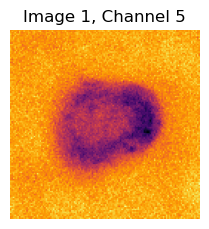

In [52]:
plt.figure(figsize=(20, 20))
print(X_realA.shape)

img = X_realA[31,:, :]
plt.subplot(1, 7, 0 * 7 + j + 1)
plt.imshow(img, cmap='inferno')
plt.title(f'Image {1}, Channel {j}')
plt.axis('off')

plt.show()


(32, 128, 128, 6)
2234.1626 3785.3398
2341.623 3887.085
1363.2388 3505.7505
1591.1594 2806.966
4277.33 9126.109
82.51749 848.92114


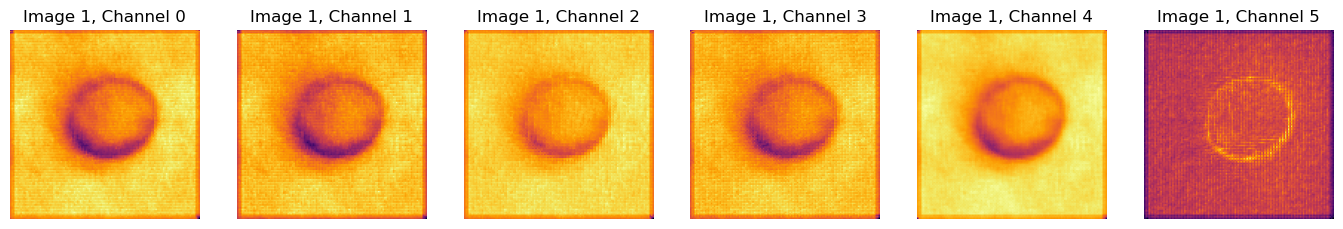

In [54]:

plt.figure(figsize=(20, 20))
print(X_fakeB.shape)
for j in range(X_fakeB.shape[-1]):
    img = X_fakeB[0,:, :, j]
    plt.subplot(1, 7, 0 * 7 + j + 1)
    plt.imshow(img, cmap='inferno')
    plt.title(f'Image {1}, Channel {j}')
    plt.axis('off')
    print(img.min(), img.max())

plt.show()
